## Starting Functions

__Reading the static data__

In [2]:
d = pd.read_pickle('A123_OCV_Static.pkl')

__Nested Key Finding Function__

In [3]:
def nest_key(d, indent=0):
    
    for key, value in d.items():
        
        print('\t' * indent + f'{key}')
        
        if isinstance(value, dict):
            
            nest_key(value, indent+1)

In [4]:
nest_key(d)

N05
	S1
		time
		step_idx
		current
		voltage
		charge_cap
		discharge_cap
	S2
		time
		step_idx
		current
		voltage
		charge_cap
		discharge_cap
	S3
		time
		step_idx
		current
		voltage
		charge_cap
		discharge_cap
	S4
		time
		step_idx
		current
		voltage
		charge_cap
		discharge_cap
N15
	S1
		time
		step_idx
		current
		voltage
		charge_cap
		discharge_cap
	S2
		time
		step_idx
		current
		voltage
		charge_cap
		discharge_cap
	S3
		time
		step_idx
		current
		voltage
		charge_cap
		discharge_cap
	S4
		time
		step_idx
		current
		voltage
		charge_cap
		discharge_cap
N25
	S1
		time
		step_idx
		current
		voltage
		charge_cap
		discharge_cap
	S2
		time
		step_idx
		current
		voltage
		charge_cap
		discharge_cap
	S3
		time
		step_idx
		current
		voltage
		charge_cap
		discharge_cap
	S4
		time
		step_idx
		current
		voltage
		charge_cap
		discharge_cap
P05
	S1
		time
		step_idx
		current
		voltage
		charge_cap
		discharge_cap
	S2
		time
		step_idx
		current
		voltage
		charge_cap
		disc

__Blending function for Internal Resistance__

In [5]:
def blend(start,stop,size):
    
    mult = np.linspace(0,1,size)
    dum = start + (start - stop)*mult   
    
    return dum

__Raw OCV calculations__

In [6]:
def ocv_vs_soc(data,SOC):

    # Total battery capacity 
    # Should be same at all the temperatures if battery degradation is not present

    Q = (np.array(data['S1']['discharge_cap'])[-1] + \
           np.array(data['S2']['discharge_cap'])[-1] - \
           np.array(data['S1']['charge_cap'])[-1] - \
           np.array(data['S2']['charge_cap'])[-1])

    # Script 1 : Step 2
    # Discharge voltage drop in slow discharge step

    df = pd.DataFrame(data['S1'])
    idx1 = df[df['step_idx'] == 2].index

    # Voltage drop at the beginning of the discharge
    IR1D = data['S1']['voltage'][idx1[0]-1] - data['S1']['voltage'][idx1[0]]

    # Voltage drop at the end of the discharge
    IR2D = data['S1']['voltage'][idx1[-1]+1] - data['S1']['voltage'][idx1[-1]]

    # Script 3 : Step 6
    # Discharge voltage drop in slow discharge step

    df = pd.DataFrame(data['S3'])
    idx2 = df[df['step_idx'] == 2].index

    # Voltage rise at the beginning of the charge
    IR1C = data['S3']['voltage'][idx2[0]] - data['S3']['voltage'][idx2[0]-1]

    # Voltage rise at the end of the charge
    IR2C = data['S3']['voltage'][idx2[-1]] - data['S3']['voltage'][idx2[-1]+1]

    # Bounds on battery internal resistance
    IR1D = min(IR1D, 2*IR2C)
    IR2D = min(IR2D, 2*IR1C)
    IR1C = min(IR1C, 2*IR2D)
    IR2C = min(IR2C, 2*IR1D)

    # Discharge internal resistance variation

    IRD = blend(IR1D,IR2D,len(idx1))

    # Approximate discharge voltage in the absence of IR

    disV = data['S1']['voltage'][idx1] + IRD

    # Approximate SOC calculation in discharge

    disZ = 1 - data['S1']['discharge_cap'][idx1]/Q
    disZ = np.array(disZ) + (1-np.array(disZ)[0])

    # Charge internal resistance variation

    IRC = blend(IR1C,IR2C,len(idx2))

    # Approximate charge voltaage in the absence of IR

    chgV = data['S3']['voltage'][idx2] - IRC

    # Approximate SOC calculation in charge

    chgZ = data['S3']['charge_cap'][idx2]/Q
    chgZ = np.array(chgZ) - np.array(chgZ)[0]


    # Logic used for combining the discharge and charge curves to approx 50% curve

    deltaV50 = np.interp(0.5, chgZ, chgV) - np.interp(0.5, disZ[::-1], disV[::-1])

    ind = np.where(chgZ < 0.5)[0]
    vChg = np.array(chgV)[ind] - np.array(chgZ[ind])*deltaV50
    zChg = chgZ[ind]

    ind = np.where(disZ > 0.5)[0]
    vDis = np.array(disV)[ind] + (1 - np.array(disZ)[ind])*deltaV50
    zDis = disZ[ind]

    # rawocv now has our best guess of true ocv at this temperature
    rawocv = np.interp(SOC, np.concatenate([zChg, zDis[::-1]]), np.concatenate([vChg, vDis[::-1]]))
    
    return (rawocv,data['S1']['voltage'][idx1],disZ,data['S3']['voltage'][idx2],chgZ,Q)


## Main Code for Calculation

In [7]:
out_d = {}

__Calculations at 25°C__

In [8]:
data_25 = d['P25']

script_list = list(data_25.keys())

total_dis_cap = 0
total_chg_cap = 0

# range for state of charge
SOC = np.arange(0, 1+0.005, 0.005).round(decimals=3) 

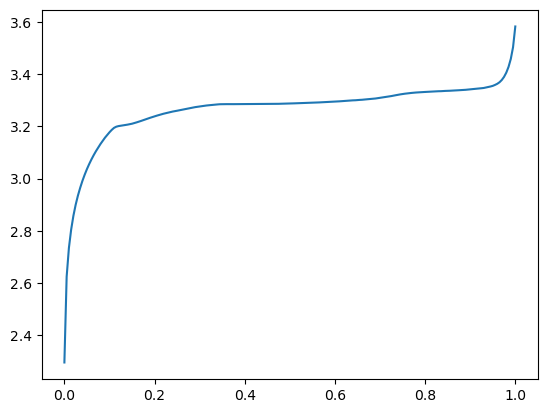

In [9]:
# Total Discharge Capacity

for i in script_list:
    
    total_dis_cap = total_dis_cap + np.array(data_25[i]['discharge_cap'])[-1]
    
# total Charging Capacity

for i in script_list:
    
    total_chg_cap = total_chg_cap + np.array(data_25[i]['charge_cap'])[-1]

# Coloumb efficiency calculation

eta25 = total_dis_cap/total_chg_cap

# Adjusting the charge capacity 

for i in script_list:
    
    data_25[i]['charge_cap'] = eta25*data_25[i]['charge_cap']

# OCV calculation at 25°C

(ocv,disV,disZ,chgV,chgZ,Q) = ocv_vs_soc(data_25,SOC)

# Storing the data in the dictionary

out_d['P25'] = {}

out_d['P25']['ocv'] = ocv
out_d['P25']['SOC'] = SOC
out_d['P25']['disV'] = disV
out_d['P25']['disZ'] = disZ
out_d['P25']['chgV'] = chgV
out_d['P25']['chgZ'] = chgZ
out_d['P25']['eta'] = eta25
out_d['P25']['Q'] = Q


plt.plot(SOC,ocv)
plt.show()

__Calculation at any temperature__

In [10]:
temp_list = list(d.keys())
temp_list.remove("P25")

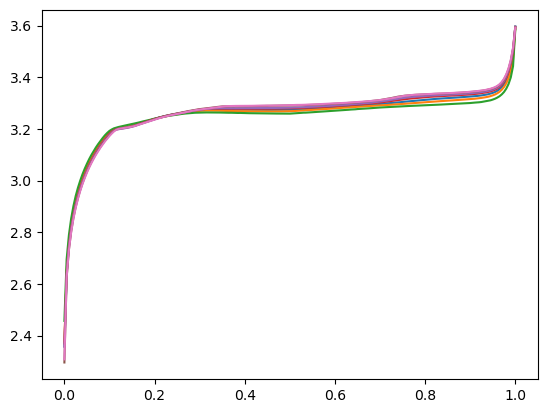

In [11]:
for temp in temp_list:
    

    data = d[temp]
    total_dis_cap = 0
    total_chg_cap = 0
    
    data['S2']['charge_cap'] = eta25*data['S2']['charge_cap']
    data['S4']['charge_cap'] = eta25*data['S4']['charge_cap']

    # Total Discharge Capacity

    for i in script_list:

        total_dis_cap = total_dis_cap + np.array(data[i]['discharge_cap'])[-1]

    total_dis_cap = total_dis_cap - np.array(data['S2']['charge_cap'])[-1] - np.array(data['S4']['charge_cap'])[-1]

    # total Charging Capacity

    for i in script_list:

        total_chg_cap = total_chg_cap + np.array(data[i]['charge_cap'])[-1]

    total_chg_cap = total_chg_cap - np.array(data['S2']['charge_cap'])[-1] - np.array(data['S4']['charge_cap'])[-1]

    # Coloumb efficiency calculation

    eta = total_dis_cap/total_chg_cap

    # Adjusting the charge capacity 

    for i in ['S1','S3']:

        data[i]['charge_cap'] = eta*data[i]['charge_cap']


    # OCV calculation at any temperature

    (ocv,disV,disZ,chgV,chgZ,Q) = ocv_vs_soc(data,SOC)
    
    # Storing the data in the dictionary

    out_d[temp] = {}

    out_d[temp]['ocv'] = ocv
    out_d[temp]['SOC'] = SOC
    out_d[temp]['disV'] = disV
    out_d[temp]['disZ'] = disZ
    out_d[temp]['chgV'] = chgV
    out_d[temp]['chgZ'] = chgZ
    out_d[temp]['eta'] = eta
    out_d[temp]['Q'] = Q


    plt.plot(SOC,ocv)

__Storing the data in pickle format__

In [12]:
import pickle

f = open("A123_OCV_vs_SOC_data.pkl","wb")

pickle.dump(out_d,f)

# close file
f.close()